# **<center>Data Wrangling**

#### Import Packages

In [1]:
import os
from dotenv import load_dotenv

import datetime as dt

from tqdm import tqdm

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

from statsmodels.stats.outliers_influence import variance_inflation_factor

#### Set Correct Options for the Notebook

In [2]:
# Load in the dotenv variables
load_dotenv()
# Show all the columns in the .head() method
pd.set_option('display.max_columns', None)
# Turn all plots dark to help my eyes
plt.style.use('dark_background')

The data was taken from kaggle and contains [Loan Data](https://www.kaggle.com/datasets/ranadeep/credit-risk-dataset?select=loan) information on the borrowers. Below I used Kaggle's API to download the dataset. I had trouble getting it to work inline in the notebook so I used these commands in the terminal.

In [101]:
'''
# Download the data from the kaggle api
kaggle datasets download -d ranadeep/credit-risk-dataset
# unzip the data 
unzip credit-risk-dataset.zip -d credit-risk-dataset 
'''

'\n# Download the data from the kaggle api\nkaggle datasets download -d ranadeep/credit-risk-dataset\n# unzip the data \nunzip credit-risk-dataset.zip -d credit-risk-dataset \n'

#### Set Directory

In [3]:
# Get the path from the environment from the dotenv file without extra add-ons
project_path = os.getenv('Project_Path')[2:78]

# Change notebook directory back one so that it can acess the data
os.chdir(project_path)

#### Load the Data

In [4]:
# Load in the data with low_memory as False so that it can understand dtype
loan = pd.read_csv('./data/raw/loan.csv', low_memory = False)
# Print out the shape of the dataset
print(loan.shape)
# Print out a sample of the dataset
loan.head()

(887379, 74)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,35.0,NaN,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-2015,357.48,NaN,Jan-2015,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,38.0,NaN,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-2016,67.79,Feb-2016,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Find when the dataset was from by looking at the most recent last payment date and the next payment dates.

In [10]:
print(max(pd.to_datetime(loan['next_pymnt_d'].fillna(0))))
print(max(pd.to_datetime(loan['last_pymnt_d'].fillna(0))))

2016-03-01 00:00:00


C:\Users\jdrel\AppData\Local\Temp\ipykernel_33248\3030356786.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  print(max(pd.to_datetime(loan['last_pymnt_d'].fillna(0))))


2016-01-01 00:00:00


The data is large and complex. In the `read_csv()` function I had to specify `low_memory = False` because some columns had too many different data types for the `read_csv()` function to be able to quickly determine the data type of each column. 

The first step in data wrangling is to separate the features (X) from the target variable (y). When I initially started this project, I had believed `loan_status` was the target variable because was a clear representation of how the loan had fared and the project description on Kaggle agreed. After much data wrangling and looking closely at the data, I realized that it was hard to use many of the features while having `loan_status` be the target variable. Too many of the features have information on the loan after origination making it not clear if they were a part of the features or the target variable. An example of this is `next_pymnt_d` which represents the date that the next payment is due. If I wanted to create a model that evaluated loans on behalf of investors as an audit of Lending Club, it would not be possible to know if there is a next payment date during the term of the loan as that is determinative of the status of the loan.
A model that uses semi target variables as its X will be great in training but will generalize worse than the Washington Generals. 


In order to use many of the features of the dataset, I need a question that has a later time frame. If I try to find how much each borrower will still pay back on their loans, I can use the features that are during the term of the loan. This can create a market or evaluation for the value of the existing loans that would be valuable for loan investors or institutions who are thinking of selling off their loans for immediate liquidity.

Below I separated out every column of the dataset that had information on the amount that the borrower has already paid and the amount that they owe. With the remaining columns I'll be able to create a multiplier that will provide an estimate on how much the borrower will pay.

In [104]:
# Create the features dataframe
X = loan.drop(['out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
               'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee','recoveries',
               'collection_recovery_fee', 'loan_status'], axis = 1)
# Separate out the target variable
y = loan[['out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
          'total_rec_int', 'total_rec_late_fee','recoveries', 'collection_recovery_fee']]

## Cleaning up the Dataset

#### Unique Values
The easiest features to clean are ones that have constant values since they provide no information. Below I looked at how many unique values each feature has. I will drop every feature that has only 1 unique value.

In [105]:
X.nunique().sort_values(ascending = True)

policy_code                 1
pymnt_plan                  2
application_type            2
initial_list_status         2
term                        2
                        ...  
emp_title              299271
tot_cur_bal            327342
url                    887379
member_id              887379
id                     887379
Length: 64, dtype: int64

In [106]:
# Drop the 'policy_code' feature since there is only one policy code
X.drop('policy_code', axis = 1, inplace = True)

### Categorical Columns

In order to analyze the data, all of the features have to have only numerical values. Some columns contain numbers but need to be cleaned in order to be fully numeric where as others are purely categorical and either need to be one-hot encoded or dropped if they have too many unique values.

Below I printed out a list of all of the categorical columns.

In [107]:
# Use dtypes to find all of the columns that are not int or float in X
[X.dtypes.index[i] for i,type in enumerate(X.dtypes) if type not in ('int64','float64', 'uint8')]

['term',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'last_pymnt_d',
 'next_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'verification_status_joint']

##### `term` of the loan

In [108]:
X['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

The `term` variable represents how long loan is for and has two values: ` 36 months` and ` 60 months`. I can convert those strings to 3, and 5 respectively to represent the years.

In [109]:
# replace the string values with numerical values, use a dictionary to be concise
X['term'].replace({' 36 months':3, ' 60 months':5}, inplace = True)
# Show the column
X['term']

0         3
1         5
2         3
3         3
4         5
         ..
887374    3
887375    3
887376    5
887377    5
887378    3
Name: term, Length: 887379, dtype: int64

##### `grade` and `sub_grade` for the loans

In [110]:
# Show all the different possible grades
print('Grade:', X['grade'].unique())

# Show all the different possible sub grades
print('Grade:', X['sub_grade'].unique())

Grade: ['B' 'C' 'A' 'E' 'F' 'D' 'G']
Grade: ['B2' 'C4' 'C5' 'C1' 'B5' 'A4' 'E1' 'F2' 'C3' 'B1' 'D1' 'A1' 'B3' 'B4'
 'C2' 'D2' 'A3' 'A5' 'D5' 'A2' 'E4' 'D3' 'D4' 'F3' 'E3' 'F4' 'F1' 'E5'
 'G4' 'E2' 'G3' 'G2' 'G1' 'F5' 'G5']


There is also the subgrade column which differentiates the quality of loans within the different grades. Since there are 5 subgrades for each grade, I can convert the subgrade to .2 downgrade of the grade

In [111]:
# Convert the grades into numbers that can be analyzed
X['grade'] = X['grade'].replace({'A':7, 'B':6, 'C':5, 'D':4, 'E':3, 'F':2, 'G':1})
# Add in the subgrade as a .2 change in the grade
X['grade'] = [X['grade'][i] - ((int(sub[-1]) - 1)/5) for i, sub in enumerate(X['sub_grade'])]
# Show the grade
X['grade']

0         5.8
1         4.4
2         4.2
3         5.0
4         5.2
         ... 
887374    5.2
887375    5.2
887376    3.8
887377    2.6
887378    5.2
Name: grade, Length: 887379, dtype: float64

With grade incorporating both `grade` and `sub_grade`, I can drop `sub_grade`.

In [112]:
# Drop sub_grade from X
X.drop('sub_grade', axis = 1, inplace = True)


##### `emp_title`: The type of employment for the borrower.

In [113]:
X['emp_title'].unique()

array([nan, 'Ryder', 'AIR RESOURCES BOARD', ..., 'machining Cell Lead',
       'KYC Business Analyst', 'Manager Hotel Operations Oasis '],
      dtype=object)

Unfortunately it appears that many of the borrowers put the name of their employer instead of their profession. I can confirm this better by using the `value_counts()` method from pandas.

In [114]:
X['emp_title'].value_counts()

Teacher                                     13469
Manager                                     11240
Registered Nurse                             5525
Owner                                        5376
RN                                           5355
                                            ...  
Thomas J. Paul, Inc.                            1
Piggie Toes Preschool                           1
greystone park psychiatric hospital             1
Las Vegas Motropolitan Police Department        1
Manager Hotel Operations Oasis                  1
Name: emp_title, Length: 299271, dtype: int64

While the most common values are types of professions, it appears that there are many values that have just the name of the employers. If I take a look at all of the values in `emp_title` that appear over 1000 times I'll get a better sense of the common professions I should try to simplify the column into.

In [115]:
# find all the different types of jobs that the borrower could have
print(len(X['emp_title'].value_counts()[X['emp_title'].value_counts() > 1000]))
# See how common each of the different employment types
X['emp_title'].value_counts()[X['emp_title'].value_counts() > 1000]

48


Teacher                     13469
Manager                     11240
Registered Nurse             5525
Owner                        5376
RN                           5355
Supervisor                   4983
Sales                        4212
Project Manager              3988
Driver                       3569
Office Manager               3510
General Manager              3178
Director                     3156
manager                      3138
teacher                      2925
owner                        2849
Engineer                     2671
President                    2598
driver                       2429
Vice President               2351
Attorney                     2136
Operations Manager           2071
Accountant                   2035
Administrative Assistant     2019
Sales Manager                1846
Account Manager              1725
sales                        1724
Police Officer               1720
supervisor                   1675
Executive Assistant          1603
Analyst       

What stands out in this column is that many of the employment types seem to be variations on the same profession. For instance there are a lot of different kinds of managers even though they are all in the managerial profession. I can combine all of these to create a much more consolidated column.

Below I created a dictionary where the keys are the profession and the values are lists of all phrases that would be associated with that profession.

In [116]:
Professions = {'Manager':['manag','supervisor','superintendent', ' lead ', 'foreman'], 
               'Healer':['nurse', 'nursing', 'cna', 'lpn', 'physician', 'doctor', 'pharmacist', 'counselor', 'therapist', 'rn', 'paramedic'],
               'Technical': ['engineer','mechanic', 'electrician', 'machinist', 'machining', 'technician', 'it', 'software', 'tech','welder'], 
               'Executive':['president', 'owner', 'ceo', 'partner', 'vp'], 'Designer': ['designer'],
               'Vol': ['firefighter', 'social worker', 'army', 'officer', 'sheriff', 'deputy', 'sergeant', 'agent', 'colonel','USAF'],
               'Director':['director', 'coordinator'], 'Accountant':['accountant', 'bookkeeper', 'controller','accounting'], 'Sales':['sales', 'realt'], 
               'Finance':['financial','underwriter', 'broker', 'cfo','bank'], 'Analyst':['analyst','consult', 'analysis','estimator'], 
               'Clergy':['pastor','rabbi','priest', 'imam', 'minister'], 'Clerk':['clerk'],
               'Service':['bartender', 'server', 'service', 'diner', 'grill', 'attendant', 'cashier','aesthetician', 'dealer', 'cook','chef'], 
               'Manlab':['maintenance','maintenence','laborer','lumber', 'custodian','carpenter'],
               'Operator':['operator','pilot', 'driver'], 'Assistant':['assistant', 'secretary','receptionist'], 'Law':['attorney','esq','paralegal'],
               'Education':['teacher','principal','professor','school','educator'], 'Admin':['admin']}

Below I created a new column that assumed that all missing values were unemployed. Then I iterated through the `Professions` dictionary and for each value I searched through the entire column to see if any cells contained that value. If they did, then I changed the entire cell to be the corresponding key from the dictionary.

In [117]:
# Fill in the missing values with unemployed for analysis
X['emp_title_cons'] = X['emp_title'].fillna('Unemployed')
for key, value in tqdm(Professions.items()):
    for v in value:
        # Create a boolean mask for all employments that are managerial
        prof = X['emp_title_cons'].str.contains(v, case=False)
        # Change the value of those to 'Manager'
        X.loc[prof, 'emp_title_cons'] = key

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:32<00:00,  1.65s/it]


With the employment titles consolidated, I can look at the employment titles with over 1000 instances again to see how effective the grouping was.

In [118]:
# find all the different types of jobs that the borrower could have
print(len(X['emp_title_cons'].value_counts()[X['emp_title_cons'].value_counts() > 1000]))

# See how common each of the different employment types
X['emp_title_cons'].value_counts()[X['emp_title_cons'].value_counts() > 1000]

22


Manager              141239
Technical            119770
Unemployed            51462
Healer                50322
Director              32973
Education             29821
Executive             28111
Vol                   25647
Operator              24758
Service               22252
Analyst               21481
Assistant             18877
Sales                 17653
Finance               12007
Accountant            10458
Admin                  9648
Manlab                 5969
Clerk                  5333
Designer               2466
Law                    1942
Clergy                 1392
Account Executive      1072
Name: emp_title_cons, dtype: int64

There is a marked improvement here with "Manager" accounting for over 150,000 of the observations. It is possible that some of the profession types are mistakes but I intentionally put spaces before and after 'lead' so that the code would only capture instances of the word lead itself.

Below I changed the `emp_type` column to have only professions with more than 1000 instances. The rest I classified as other.

In [119]:
common_proffs = X['emp_title_cons'].value_counts()[X['emp_title_cons'].value_counts() > 1000]
# Create a feature that has the most common profession types, store the rest as other.
X['emp_type'] = [x if x in common_proffs.index else 'other' for x in X['emp_title_cons']] 

With a workable list of professions that the borrowers have, I can one-hot encode them for later analysis and drop the columns that created `emp_type`.

In [120]:
# Convert all of the columns into dummy variables
X = pd.get_dummies(X, columns = ['emp_type'], drop_first = True)

# Drop emp_title and emp_title_cons now that there is no need for them.
X.drop(['emp_title', 'emp_title_cons'], axis = 1, inplace = True)

##### `emp_length`: employment length of the borrower.

In [121]:
# Show all of the different employement lengths
X['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

This column appears to have numerical values that are encased in strings. If I can separate the number from the surrounding string and change its type to a number than this column can become numerical.

In [122]:
# Replace the non-existant values with 0
X['emp_length'] = X['emp_length'].fillna(0)
# Replace the less than one year with the average of .5
X['emp_length'] = X['emp_length'].replace('< 1 year', 0.5)
# Get rid of all non-numerical characters to convert the values into numerical
X['emp_length'] = X['emp_length'].replace(r'[a-zA-Z+]', '', regex = True)
# Change the type from string to numerical
X['emp_length'] = X['emp_length'].astype('float')

##### `home_ownership`: The housing situation of the borrower

In [123]:
# Look at all the types of home ownership
X['home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE', 'ANY'], dtype=object)

Since `OTHER`, `NONE`, and `ANY` can all mean the same thing, I think it best to combine the three of them into `OTHER`

In [124]:
# Switch home_ownership rare values to other.
X['home_ownership'].replace({'NONE': 'OTHER','ANY':'OTHER'}, inplace = True)

With a consolidated `home_ownership` column, I can now one-hot encode it for later analysis

In [125]:
# Create dummy columns for the different types of home ownership
X = pd.get_dummies(X, columns = ['home_ownership'], drop_first = True)

##### `verification_status`: Whether or not Lending club was able to verify the information the borrower submitted.

In [126]:
X['verification_status'].unique()

array(['Verified', 'Source Verified', 'Not Verified'], dtype=object)

`verification_status` has 3 unique values that determine if the information has been verified, the source of the information has been verified or if neither the source nor the information has been verified. I will make this into a dummy variable later on.

In [127]:
# Create dummy variables for the different verification statuses
X = pd.get_dummies(X, columns = ['verification_status'], drop_first = True)

##### `issue_d`: the month and year in which the loan was issued.

In [128]:
X['issue_d'].head()

0    Dec-2011
1    Dec-2011
2    Dec-2011
3    Dec-2011
4    Dec-2011
Name: issue_d, dtype: object

`issue_d` is a very important feature because I'll be able to use it to determine how much time is left on the loan but it isn't a feature that will influence a borrower's ability to pay back the loan. For that reason I'll drop it from this dataset.

In [129]:
# Drop issue_d from the X dataset
X.drop('issue_d', axis = 1, inplace = True)

##### `pymnt_plan`: Indicates whether there has been a payment plan put in place for the borrower to pay off the loan that wasn't the original schedule.

In [130]:
X['pymnt_plan'].unique()

array(['n', 'y'], dtype=object)

There are only two values in this column either a 'n' for no or a 'y' for yes. Since it is a binary choice I can represent it numerically as 0 for n and 1 for y.

In [131]:
# Convert pyment_plan to a binary variable
X['pymnt_plan'] = np.where(X['pymnt_plan'] == 'y', 1, 0)


##### `url` of the page that contains the loan. Needs a login to access it.

In [132]:
X['url'].unique()

array(['https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077501',
       'https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077430',
       'https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077175',
       ...,
       'https://www.lendingclub.com/browse/loanDetail.action?loan_id=36271333',
       'https://www.lendingclub.com/browse/loanDetail.action?loan_id=36490806',
       'https://www.lendingclub.com/browse/loanDetail.action?loan_id=36271262'],
      dtype=object)

The URL column appears to be the same website with the id column as the `loan_id` at the end of it. I can test this by trying to see if the characters up until the `id=` are always the same.

In [133]:
# Grab the first part of the url and see if it always the same.
X['url'].str[:61].unique()

array(['https://www.lendingclub.com/browse/loanDetail.action?loan_id='],
      dtype=object)

Now that I know that the start of the `url` is always the same I can check to see if the ID part of the `url` is the exact same as the `id` column itself. 

In [134]:
# subtract the set of the id part of the url column from the id column.
set(X['id']) - set(X['url'].str[61:].astype('int'))

set()

The code above returned an empty set which means that there is no difference between the id column and the number at the end of the `url`. This means that the url is redundant and can be dropped. 

In [135]:
# Drop the url column from X
X.drop('url', axis = 1, inplace = True)

##### `desc`: A summary for the reason the borrower is taking the loan

In [136]:
# Find how many people didn't put a description
print(X['desc'].isna().sum())

# Print a sample of some of the descriptions
X['desc'].unique()

761351


array(['  Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>',
       '  Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up.<br><br>  Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces<br>',
       nan, ...,
       'I need a lower interest loan to pay off my citifinancial loan.  ',
       'I am looking for a loan to pay my credit cards off as well as making some very much needed auto repairs',
       'I am in my senior year of college in obtaining a bachelors degree in criminal justice.  I do not

The `desc` variable is significantly more in depth than the `title` or `purpose` variable but unfortunately most of the borrowers never submitted one. Since most of the important information that could be gleaned from the `desc` column is most likely contained within `title` and `purpose` which have litle to no missing values, I will drop this column.

In [137]:
X.drop('desc', axis = 1, inplace = True)

##### `purpose`: The reason the borrower applied and took the loan

In [138]:
# View all the unique reasons for why people are getting a loan.
X['purpose'].unique()

array(['credit_card', 'car', 'small_business', 'other', 'wedding',
       'debt_consolidation', 'home_improvement', 'major_purchase',
       'medical', 'moving', 'vacation', 'house', 'renewable_energy',
       'educational'], dtype=object)

This column needs to be one-hot encoded since there are no clear numerical map for the categorical values of this column. .

In [139]:
X = pd.get_dummies(X, columns = ['purpose'], drop_first = True)

##### `title`: The title that the borrower put for the loan

In [140]:
print(len(X['title'].unique()))
X['title'].unique()

63145


array(['Computer', 'bike', 'real estate business', ...,
       'new kitchen for momma!',
       'New Baby and New House (CC Consolidate)',
       'Credit Card/Auto Repair'], dtype=object)

This appears to be a worse version of purpose as there are over 63,000 different titles and the content from them appears to be very similar to the content in the `purpose` variable. For that reason I'll drop `title` 

In [141]:
X.drop('title', axis = 1, inplace = True)

##### `zip_code`: The borrower's zipcode

In [142]:
print(len(X['zip_code'].unique()))
X['zip_code'].head()

935


0    860xx
1    309xx
2    606xx
3    917xx
4    972xx
Name: zip_code, dtype: object

While it looks like there are numbers to be used in this column, these are zipcodes and not orders of magnitude. Therefore if I removed the xs I would still have a categorical column. I could one-hot encode the zip codes but that would produce over 800 million values and I'm not sure that my laptop would be able to easily run calculations on that amount of data so the simplest thing to do is to drop them. 

In [143]:
# Drop zip_code from the X dataset
X.drop('zip_code', axis = 1, inplace = True)

##### `addr_state`: Initials for the state the borrower is from

In [144]:
# Print out the number of states that are used
print(len(X['addr_state'].unique()))
# Print out the list of states used.
(X['addr_state'].unique())

51


array(['AZ', 'GA', 'IL', 'CA', 'OR', 'NC', 'TX', 'VA', 'MO', 'CT', 'UT',
       'FL', 'NY', 'PA', 'MN', 'NJ', 'KY', 'OH', 'SC', 'RI', 'LA', 'MA',
       'WA', 'WI', 'AL', 'CO', 'KS', 'NV', 'AK', 'MD', 'WV', 'VT', 'MI',
       'DC', 'SD', 'NH', 'AR', 'NM', 'MT', 'HI', 'WY', 'OK', 'DE', 'MS',
       'TN', 'IA', 'NE', 'ID', 'IN', 'ME', 'ND'], dtype=object)

While there are 50 states, there are borrowers from Washington, D.C. brings the total to 51. Unlike zipcodes, 51 is a much more reasonable number to one-hot encode.

In [145]:
# Create a dummy variable for each state that a borrower is from
X = pd.get_dummies(X, columns = ['addr_state'], drop_first = True)

##### `earliest_cr_line`: The date of the earliest line of credit that the borrower had

In [146]:
print(X['earliest_cr_line'].isna().sum())
print(X['earliest_cr_line'].dtype)
X['earliest_cr_line'].head()

29
object


0    Jan-1985
1    Apr-1999
2    Nov-2001
3    Feb-1996
4    Jan-1996
Name: earliest_cr_line, dtype: object

While it does appear that this column is in a datetime format, it is actually on object that needs to be converted. There are still 29 missing values but I will fill them in with the `issue_d` as the loan itself is a form of credit.

In [147]:
# Fill in missing dates for the earliest credit line column 
X['earliest_cr_line'] = X['earliest_cr_line'].fillna(loan['issue_d'])

# Convert the earliest credit line of the borrower 
X['earliest_cr_line'] = pd.to_datetime(X['earliest_cr_line'])

In order to include this variable in the multicollinearity and lasso calculations I need to convert it from datetime to numeric.

In [148]:
# Convert the variable from datetime to numeric.
X['earliest_cr_line'] = X['earliest_cr_line'].map(dt.datetime.toordinal)

#####  `initial_list_status`: Listing status for if the loan was offered as whole or fractional.

In [149]:
X['initial_list_status'].unique()

array(['f', 'w'], dtype=object)

'w' represents loans that were offered to institutions that would be bought as a full loan. 'f' represents loans that went straight to investors who would by a portion of the loan instead of all of it. Since there are only to values, I can binary encode this variable to have 'f' --> 0 and 'w' --> 1.

In [150]:
# Convert pyment_plan to a binary variable
X['initial_list_status'] = np.where(X['initial_list_status'] == 'w', 1, 0)

##### `last_pymnt_d`: The last time that the borrower paid lending club in mm-yyyy

In [151]:
print(X['last_pymnt_d'].isna().sum())
X['last_pymnt_d'].head(10)

17659


0    Jan-2015
1    Apr-2013
2    Jun-2014
3    Jan-2015
4    Jan-2016
5    Jan-2015
6    Jan-2016
7    Jan-2015
8    Apr-2012
9    Nov-2012
Name: last_pymnt_d, dtype: object

This variable cannot be consistent over the training and test sets that I plan to train the models on. I will drop this variable

In [152]:
X.drop('last_pymnt_d', axis = 1, inplace = True)

##### `next_pymnt_d`: The next time that the borrower is expected to pay lending club in mm-yyyy

In [153]:
print(X['next_pymnt_d'].isna().sum())
X['next_pymnt_d'].head(10)

252971


0         NaN
1         NaN
2         NaN
3         NaN
4    Feb-2016
5         NaN
6    Feb-2016
7         NaN
8         NaN
9         NaN
Name: next_pymnt_d, dtype: object

This variable has a large amount of missing values from all of the loans that have been fully paid or charged off. It is not a variable that will be consistent over the training and test sets.

In [154]:
X.drop('next_pymnt_d', axis = 1, inplace = True)

##### `last_credit_pull_d`: The last time lending club pulled the credit score of the borrower mm-yyyy

In [155]:
print(X['last_credit_pull_d'].isna().sum())
print(X['last_credit_pull_d'].dtype)
X['last_credit_pull_d'].head()

53
object


0    Jan-2016
1    Sep-2013
2    Jan-2016
3    Jan-2015
4    Jan-2016
Name: last_credit_pull_d, dtype: object

There are 53 missing values that I can fill by the issue date because lending club pulls credit for every single loan so presumably there should have been a credit pull around the issue date.

In [156]:
# Fill in missing dates for the last credit pull column 
X['last_credit_pull_d'] = X['last_credit_pull_d'].fillna(loan['issue_d'])

Similar to what I did with `earliest_cr_line` I will convert this column to numeric so that I can analyze its multicollinearity and feature importance.

In [157]:
# Convert the date that the lending company got a credit report
X['last_credit_pull_d'] = pd.to_datetime(X['last_credit_pull_d'])

X['last_credit_pull_d'] = X['last_credit_pull_d'].map(dt.datetime.toordinal)

##### `application_type`: Whether or not the loan application is joint or individual

In [158]:
X['application_type'].unique()

array(['INDIVIDUAL', 'JOINT'], dtype=object)

Since the only two values are 'INDIVIDUAL' and 'JOINT', I can use binary encoding to transform it into a numerical column by having 'INDIVIDUAL' --> 0 and 'JOINT' --> 1

In [159]:
# Convert pyment_plan to a binary variable
X['application_type'] = np.where(X['application_type'] == 'JOINT', 1, 0)

##### `verification_status_joint`: Same as the verification_status but for joint applications.

In [160]:
X['verification_status_joint'].unique()

array([nan, 'Not Verified', 'Verified', 'Source Verified'], dtype=object)

The reason why there are missing values in this column is because most of the loans are to individual people. I can fill in the nan with some value that will allow me to use the pandas funtion `get_dummies`

In [161]:
# Fill the missing values in the application.
X['verification_status_joint'].fillna('indiv')

# One-hot encode the joint verification status
X = pd.get_dummies(X, columns = ['verification_status_joint'], drop_first = False)

### **Columns to drop:**
 - **id**: This is not a relational database so there is no value in having a variable that can tie this dataset to others.
 - **member_id**: same as ID, there are no other datasets for that need a bridge variable.

In [162]:
# drop all of the columns that I had mentioned earlier.
X.drop(['id', 'member_id'], axis = 1, inplace = True)

In [163]:
X.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,annual_inc,pymnt_plan,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,emp_type_Accountant,emp_type_Admin,emp_type_Analyst,emp_type_Assistant,emp_type_Clergy,emp_type_Clerk,emp_type_Designer,emp_type_Director,emp_type_Education,emp_type_Executive,emp_type_Finance,emp_type_Healer,emp_type_Law,emp_type_Manager,emp_type_Manlab,emp_type_Operator,emp_type_Sales,emp_type_Service,emp_type_Technical,emp_type_Unemployed,emp_type_Vol,emp_type_other,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,verification_status_joint_Not Verified,verification_status_joint_Source Verified,verification_status_joint_Verified
0,5000.0,5000.0,4975.0,3,10.65,162.87,5.8,10.0,24000.0,0,27.65,0.0,724642,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,0,171.62,735964,0.0,NaN,0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2500.0,2500.0,2500.0,5,15.27,59.83,4.4,0.5,30000.0,0,1.00,0.0,729845,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,0,119.66,735112,0.0,NaN,0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2400.0,2400.0,2400.0,3,15.96,84.33,4.2,10.0,12252.0,0,8.72,0.0,730790,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,0,649.91,735964,0.0,NaN,0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,10000.0,10000.0,10000.0,3,13.49,339.31,5.0,10.0,49200.0,0,20.00,0.0,728690,1.0,35.0,NaN,10.0,0.0,5598.0,21.0,37.0,0,357.48,735599,0.0,NaN,0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3000.0,3000.0,3000.0,5,12.69,67.79,5.2,1.0,80000.0,0,17.94,0.0,728659,0.0,38.0,NaN,15.0,0.0,27783.0,53.9,38.0,0,67.79,735964,0.0,NaN,0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

## **Missing Values**

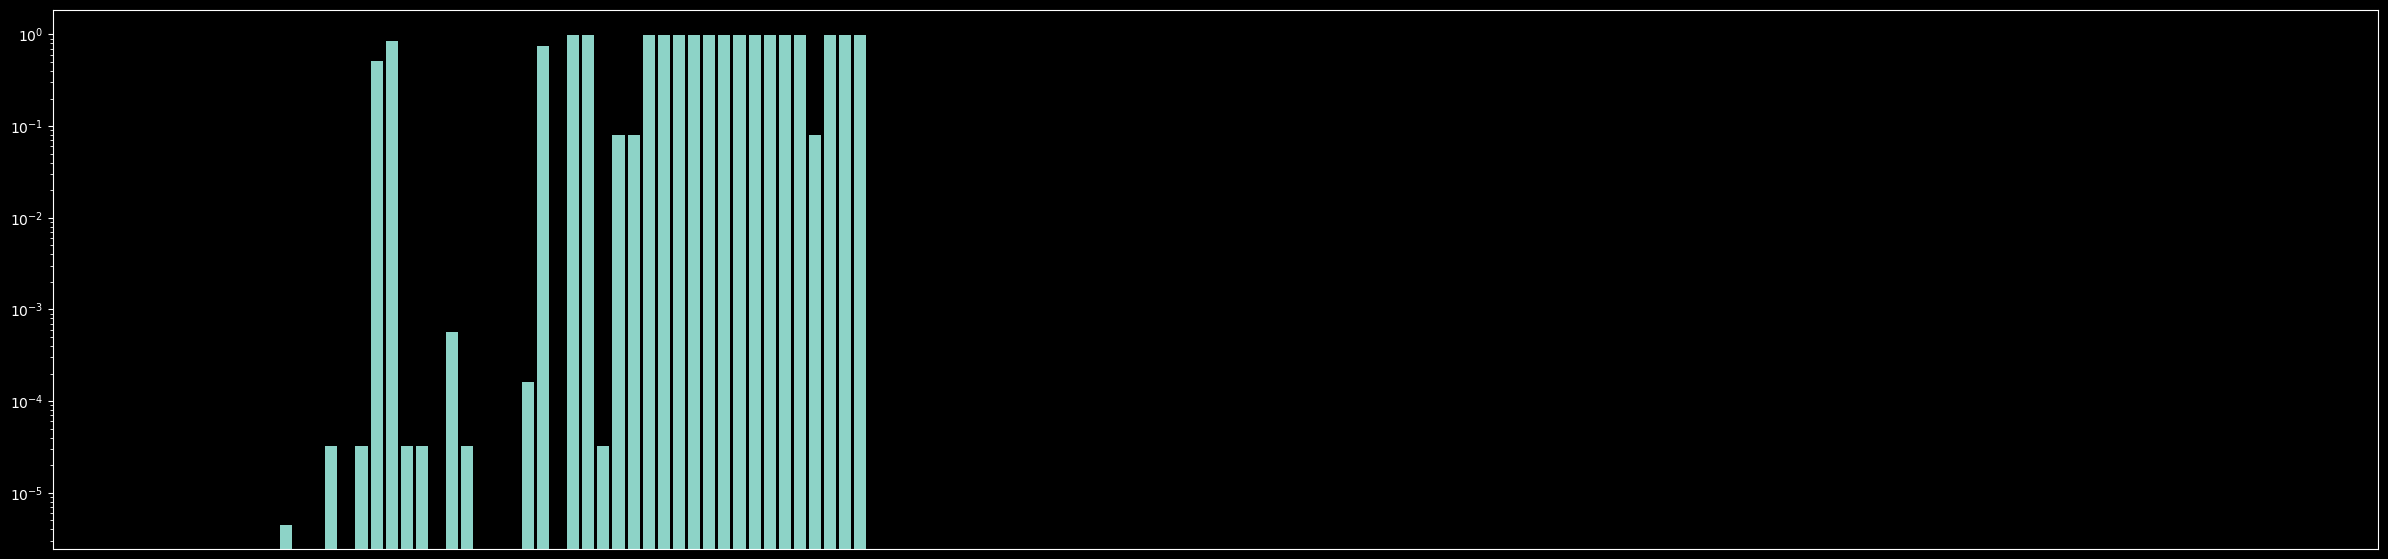

In [164]:
plt.figure(figsize = (30,7));
# Plot missing values for each column
plt.bar(x = X.columns, height = X.isna().sum()/X.shape[0])
# hide the names of the columns for a cleaner graph
plt.xticks([]);
# Set the scale to log so I can see every column that has a missing value
plt.yscale('log');

In [165]:
list(X.columns[X.isna().sum()/X.shape[0] > 0])

['annual_inc',
 'delinq_2yrs',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_util',
 'total_acc',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m']

The imputation of values for this dataset is the most challenging aspect of this project. There are many columns that have large swaths of missing values that need reasonable values filled in so as to allow the algorithms to capture the existing patterns in the data instead of artificial ones coming from synthetic data.

My assumption was that most missing values were zeroes that people forgot to fill out on forms or didn't bother with. For instance `open_il_12m` refers to the number of opened installment accounts in the last 12 months. If there isn't any information on the number of installment accounts, then there likely aren't any installment accounts. 

Values such as `mths_since_last_delinq` or months since last delinquent are different because if someone was never delinquent than the correct answer isn't 0 which would imply that they are currently delinquent but a very high number. The higher the value, the better the outcome on their loan. I can use 1000 since it is 83 years worth of non-delinquency.  

In [166]:
# Create a list with all of the columns that have missing values to be filled with 0
fill_with_zero = ['annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
                  'pub_rec', 'revol_util', 'total_acc', 'collections_12_mths_ex_med',
                  'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m',
                  'open_il_6m', 'open_il_12m', 'open_il_24m','total_bal_il', 'il_util',
                  'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim',
                  'inq_fi', 'total_cu_tl', 'inq_last_12m']

# Fill those columns with 0
X[fill_with_zero] = X[fill_with_zero].fillna(0)

In [167]:
# Create a list with all of the columns that have missing values to be filled with 1000
fill_with_1000 = ['mths_since_last_delinq', 'mths_since_last_record',
                  'mths_since_last_major_derog', 'mths_since_rcnt_il']
# Fill those columns with 0
X[fill_with_1000] = X[fill_with_1000].fillna(1000)

In [168]:
# List out all the columns that still having missing values
list(X.columns[X.isna().sum()/X.shape[0] > 0])

['annual_inc_joint', 'dti_joint']

#### Multicollinearity

Multicollinearity is the idea that more than two features share the same line. This is bad because it becomes hard to assign correlation or causation to any given feature since the math doesn't favor either feature for the outcome. 

Below I have combined some columns that have are similar in their information so that there aren't Multicollinearity concerns.

In [169]:
# Combine annual inc columns joint and indiv into one.
X['annual_inc'] = [loan['annual_inc'][i] if math.isnan(x) else x for i, x in enumerate(loan['annual_inc_joint'])]
# Create a column that documents if the column above is joint or indiv
X['inc_joint'] = np.where(loan['annual_inc_joint'].isnull(), 0, 1)

In [170]:
# Combine dti columns joint and indiv into one.
X['dti'] = [X['dti'][i] if math.isnan(x) else x for i, x in enumerate(X['dti_joint'])]
# Create a column that documents if the column above is joint or indiv
X['dti_joint'] = np.where(loan['dti_joint'].isnull(), 0, 1)

In [171]:
# Check to see if there are still missing columns
list(X.columns[X.isna().sum()/X.shape[0] > 0])

['annual_inc', 'annual_inc_joint']

In [172]:
# Drop 'annual_inc_joint' now that it has been added to 'annual_inc'
X.drop('annual_inc_joint', axis = 1, inplace = True)
# Fill in the missing values with 0 as the assumption is there is no income
X['annual_inc'].fillna(0, inplace = True)

In [173]:
# Check to see if there are still missing columns
list(X.columns[X.isna().sum()/X.shape[0] > 0])

[]

Now that the dataset if finally numerical I'm able to scale the data so that any future models won't be skewed by arbitrary size ranges.

In [174]:
# Initialize the standard scaler
scaler = StandardScaler()
# Fit and transform X into a dataframe so that I can keep using pandas
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

In [175]:
X_scaled.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,annual_inc,pymnt_plan,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,emp_type_Accountant,emp_type_Admin,emp_type_Analyst,emp_type_Assistant,emp_type_Clergy,emp_type_Clerk,emp_type_Designer,emp_type_Director,emp_type_Education,emp_type_Executive,emp_type_Finance,emp_type_Healer,emp_type_Law,emp_type_Manager,emp_type_Manlab,emp_type_Operator,emp_type_Sales,emp_type_Service,emp_type_Technical,emp_type_Unemployed,emp_type_Vol,emp_type_other,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,verification_status_joint_Not Verified,verification_status_joint_Source Verified,verification_status_joint_Verified,inc_joint
0,-1.156460,-1.155635,-1.152256,-0.654724,-0.592611,-1.121467,0.763889,1.134870,-0.789014,-0.003357,1.147690,-0.364672,-1.771866,0.305877,0.975849,0.427154,-1.607499,-0.335522,-0.145932,1.201140,-1.373775,-0.97077,-0.415561,0.302329,-0.107149,0.576897,-0.024004,-0.023957,-0.064298,-0.021004,-0.843347,-0.103891,-0.107375,-0.094692,-0.109934,0.154904,-0.100884,-0.139209,-0.105267,-0.117038,-0.116273,-0.149047,-0.79786,-0.085105,-0.076504,-0.088306,-0.109205,-0.104843,-0.157505,-0.147428,-0.039637,-0.077757,-0.052789,-0.196448,-0.186479,-0.180873,-0.117117,-0.245189,-0.046832,-0.435078,-0.082293,-0.169413,-0.142468,-0.160378,-0.395006,4.030308,-0.172517,-0.631040,-0.016276,-0.330681,1.2214,-0.768632,1.431317,1.817653,-1.201443,-0.021838,-0.249058,-0.064769,-0.140912,-0.098577,-0.078349,-0.225373,-0.025464,-0.108777,-0.073251,-0.051496,-0.113061,-0.086828,6.517162,-0.413398,-0.147149,-0.124436,-0.052423,-0.05327,-0.271536,-0.184084,-0.071949,-0.003972,-0.003677,-0.204067,-0.125636,-0.094934,-0.098635,-0.109885,-0.154136,-0.155806,-0.024331,-0.163067,-0.13532,-0.127556,-0.065744,-0.053768,-0.16928,-0.02324,-0.036428,-0.069732,-0.197322,-0.074813,-0.119254,-0.301818,-0.185863,-0.09589,-0.111481,-0.191506,-0.066381,-0.110158,-0.045272,-0.121394,-0.295217,-0.084316,-0.174612,-0.045046,-0.149636,-0.114958,-0.070478,-0.04786,-0.017861,-0.008291,-0.01372,-0.024004
1,-1.452829,-1.452198,-1.445430,1.527360,0.461735,-1.543440,-0.314193,-1.398891,-0.696292,-0.003357,-2.063920,-0.364672,0.143584,4.312132,0.975849,0.427154,-1.607499,-0.335522,-0.679268,-1.912396,-1.796028,-0.97077,-0.426398,-3.540893,-0.107149,0.576897,-0.024004,-0.023957,-0.064298,-0.021004,-0.843347,-0.103891,-0.107375,-0.094692,-0.109934,0.154904,-0.100884,-0.139209,-0.105267,-0.117038,-0.116273,-0.149047,-0.79786,-0.085105,-0.076504,-

In [176]:
# Function to get rid of all the diagonals in correlation heatmaps
def zero_diagonal_heatmap(dfx, min = 0, max = None, color_map = None, threshhold = 0):
    # give the max a base value
    if max is None:
        max = dfx.shape[1]
    # Create a numpy matrix that is easy to manipulate
    cm = np.array(abs(dfx.iloc[:,min:max].corr(numeric_only = False)))
    # Create a loop that replaces all the diagonal values with 0
    for i in range(len(cm)):
        # Loop thorough the other axis of values
        for j in range(len(cm)):
            # All diagonal values happen when i == j
            if i == j:
                # set the diagonal value equal to 0
                cm[i,j] = 0
    df_cm = pd.DataFrame(cm, columns = list(dfx.columns)[min:max], index = list(dfx.columns)[min:max])
    # Make the plot bigger
    plt.figure(figsize=(12, 8))
    # Plot the heatmap
    ax = sns.heatmap(df_cm, cmap = color_map, center = threshhold, vmin = 0, vmax = 1);

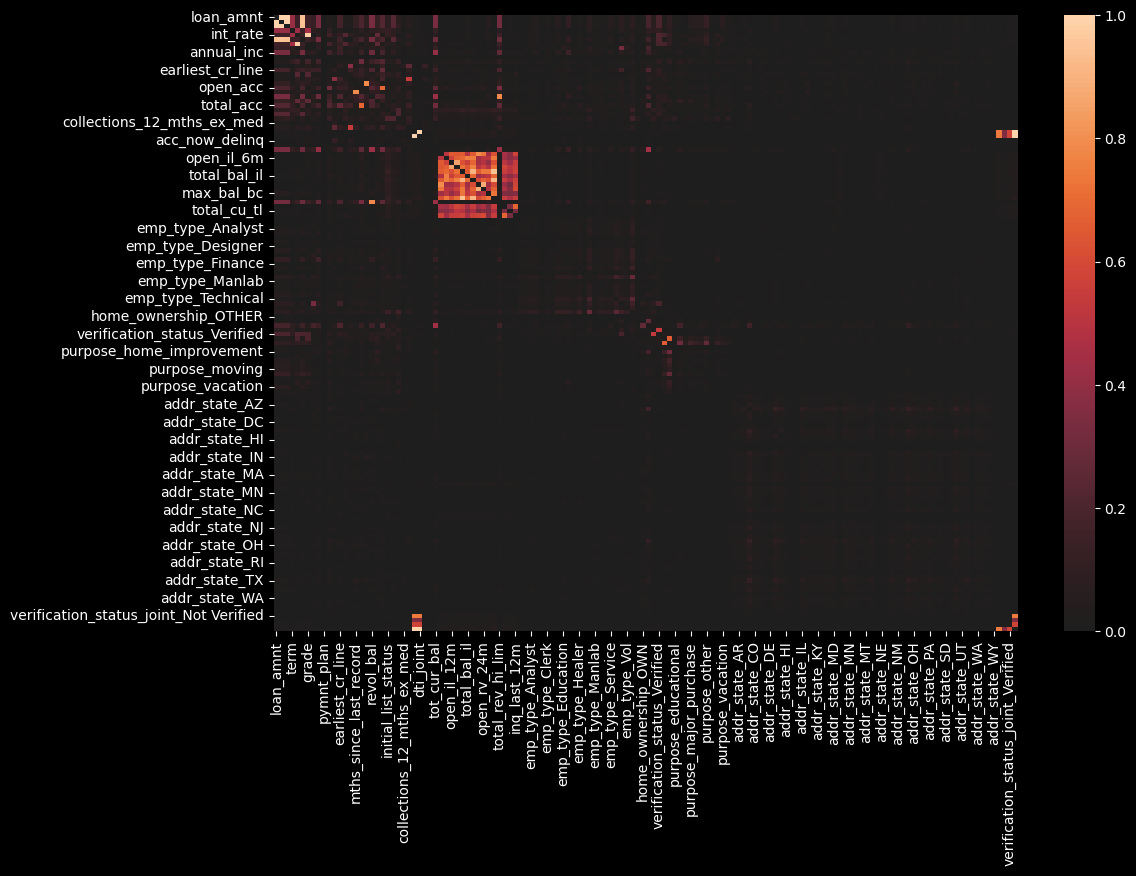

In [177]:
zero_diagonal_heatmap(X_scaled)

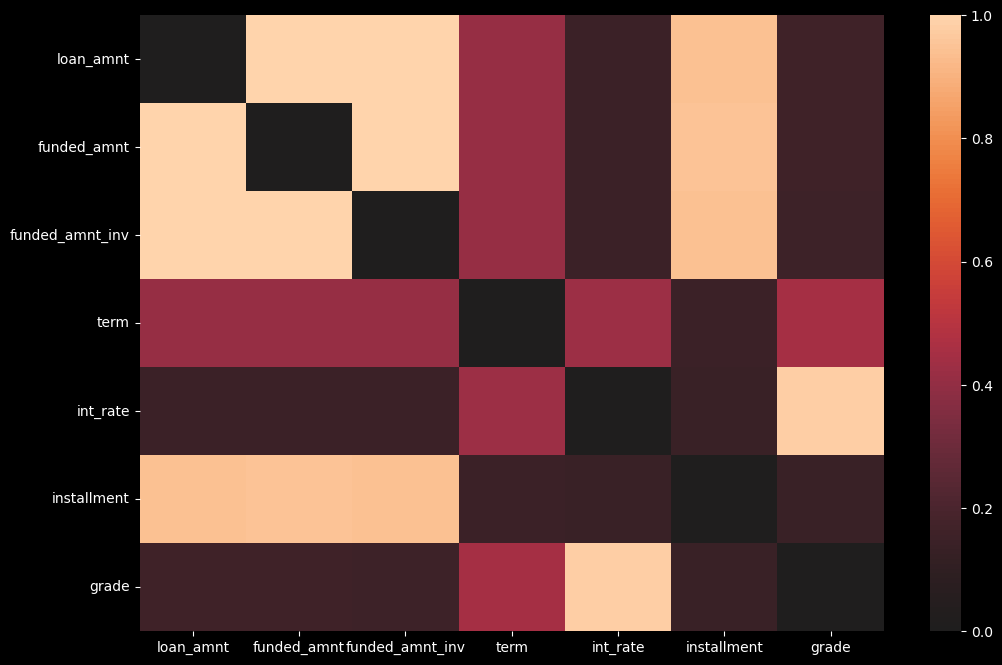

In [178]:
# Create a heatmap of the first 7 columns
zero_diagonal_heatmap(X_scaled, 0, 7)

'loan_amnt' is the amount the requested amount of money for the loan from the borrower, 'funded_amnt' is the amount of money that has been committed to the loan, and 'funded_amnt_inv is the amount of money investors have committed to the loan. Since loan amount is the only variable that the applicant has control over, I believe it is the only relevant variable to keep. 'installment' is the monthly payment if the loan originates, this is a function of the loan amount and the term and can be dropped. 'int_rate' is the interest rate of the loan and it is directly determined by the grade that lending club gives the loan. I can pick one of the two and it will contain the information of the other.

In [179]:
# Drop all the columns that are clearly collinear that are the least interesting
X_scaled.drop(['funded_amnt','funded_amnt_inv', 'installment','int_rate'], axis = 1, inplace = True)

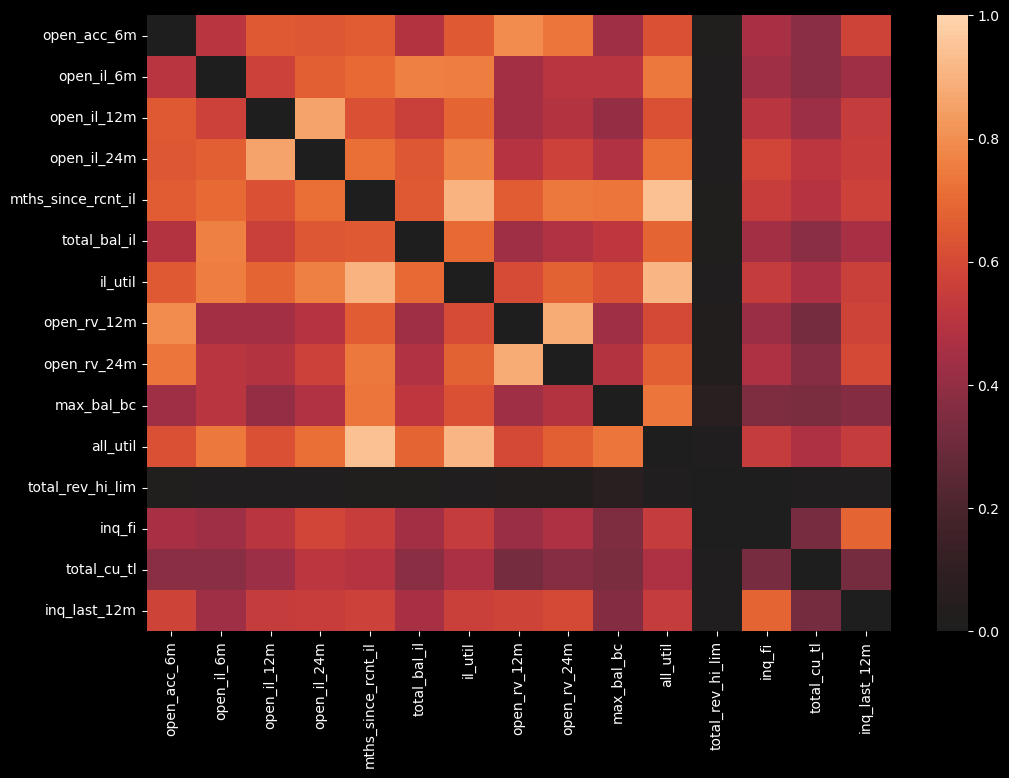

In [180]:
zero_diagonal_heatmap(X_scaled,27,42)

In [181]:
# Create a function that takes a dataframe and a correlation level 
def corr_dict(dfx, corr = 0.7):
    # Create the correlation with absolute values to measure collinearity
    corr_mat = abs(dfx.corr(numeric_only = False)) > corr   # type: ignore
    # Define the dictionary outside the function for uses
    global correl_dict
    # Create a dictionary with sorted values so that it is easy to see the next steps
    correl_dict = dict(corr_mat.sum().sort_values(ascending = False)) 
    # Subtract each value by one for the self correlation on the diagonal
    correl_dict = {key: value - 1 for key, value in correl_dict.items() if value != 1}
    # Print the dictionary
    print(correl_dict)

In [182]:
# Create a function that takes a list of features and minimum number of correlations
def corr_list(min_corr, corr, still_high_mcl = None):
    # Define the dictionary where all the information will be stored
    correlations2 = {}
    # Almost always the default value will be None
    if still_high_mcl is None:
        # # the default list is the keys from correl_dict whose values are at least min_corr
        still_high_mcl = [key for key, value in correl_dict.items() if value >= min_corr]
        # Drop all date time objects from the list by using the ending _d as an identifier
        still_high_mcl = [element for element in still_high_mcl if not element.endswith("_d")]
    # Store the correlation matrix in a variable for easy use  
    still_corr = abs(X_scaled[still_high_mcl].corr(numeric_only = True))
    # Put the index and column names as the feature names
    still_corr.columns = still_high_mcl
    still_corr.index = still_high_mcl
    # Iterate through all the features in the list
    for shm in still_high_mcl:
        # create a list of all the features that have a correlation of over 7
        corrs2 = still_corr.index[still_corr[shm] > corr].tolist() #type: ignore
        # remove the self correlation
        corrs2.remove(shm)
        # input the feature and list into the dictionary
        correlations2.update({shm: corrs2})
    # print the result    
    print(correlations2)

In [183]:
# Find the number of features each feature is correlated with
corr_dict(X_scaled)

{'all_util': 5, 'il_util': 5, 'mths_since_rcnt_il': 5, 'open_il_24m': 4, 'inc_joint': 3, 'application_type': 3, 'verification_status_joint_Not Verified': 3, 'open_rv_24m': 3, 'open_il_6m': 3, 'dti_joint': 3, 'max_bal_bc': 2, 'open_rv_12m': 2, 'total_bal_il': 2, 'open_acc_6m': 2, 'open_il_12m': 1, 'total_rev_hi_lim': 1, 'mths_since_last_record': 1, 'pub_rec': 1, 'revol_bal': 1}


In [184]:
# Get the list of features each feature is correlated with.
corr_list(corr = 0.7, min_corr = 1)

{'all_util': ['il_util', 'mths_since_rcnt_il', 'open_il_24m', 'open_il_6m', 'max_bal_bc'], 'il_util': ['all_util', 'mths_since_rcnt_il', 'open_il_24m', 'open_il_6m', 'total_bal_il'], 'mths_since_rcnt_il': ['all_util', 'il_util', 'open_il_24m', 'open_rv_24m', 'max_bal_bc'], 'open_il_24m': ['all_util', 'il_util', 'mths_since_rcnt_il', 'open_il_12m'], 'inc_joint': ['application_type', 'verification_status_joint_Not Verified', 'dti_joint'], 'application_type': ['inc_joint', 'verification_status_joint_Not Verified', 'dti_joint'], 'verification_status_joint_Not Verified': ['inc_joint', 'application_type', 'dti_joint'], 'open_rv_24m': ['mths_since_rcnt_il', 'open_rv_12m', 'open_acc_6m'], 'open_il_6m': ['all_util', 'il_util', 'total_bal_il'], 'dti_joint': ['inc_joint', 'application_type', 'verification_status_joint_Not Verified'], 'max_bal_bc': ['all_util', 'mths_since_rcnt_il'], 'open_rv_12m': ['open_rv_24m', 'open_acc_6m'], 'total_bal_il': ['il_util', 'open_il_6m'], 'open_acc_6m': ['open_rv_

One set of features that is consistently multicollinear is the features that are measured in 6 months, 12 months, and 24 months. It isn't surprising that they are collinear since they are measuring the same thing but it is important to combine them so that I can preserve their information without confusing their impact. The simplest way to do this is to set the time frame equal and then compare. 

In [185]:
# Scale the number of 6 month installment accounts to 12
X_scaled['il_6'] =  X_scaled['open_il_6m'] * 2
# Scale the number of 24 month installment accounts to 12
X_scaled['il_24'] =  X_scaled['open_il_24m'] / 2
# Take the max out of all the scaled features to find if there is a spike in install accounts.
X_scaled['open_install_acc'] = X_scaled[['il_6', 'open_il_12m', 'il_24']].max(axis = 1)

# Scale the number of 24 month revolving accounts to 12
X_scaled['rv_24'] =  X_scaled['open_rv_24m'] / 2
# Take the max out of all the scaled features to find if there is a spike in revolving accounts.
X_scaled['open_revolving'] = X_scaled[['open_rv_12m', 'rv_24']].max(axis = 1)

# Drop all the original columns now that they are useless.
X_scaled.drop(['il_6', 'open_il_12m', 'il_24', 'open_rv_12m', 'rv_24', 'open_il_6m', 'open_il_24m','open_rv_24m'], axis = 1, inplace = True)

In [186]:
# Find the number of features each feature is correlated with again.
corr_dict(X_scaled)

{'mths_since_rcnt_il': 5, 'open_install_acc': 4, 'il_util': 4, 'all_util': 4, 'inc_joint': 3, 'dti_joint': 3, 'application_type': 3, 'verification_status_joint_Not Verified': 3, 'open_revolving': 2, 'total_bal_il': 2, 'max_bal_bc': 2, 'revol_bal': 1, 'total_rev_hi_lim': 1, 'open_acc_6m': 1, 'pub_rec': 1, 'mths_since_last_record': 1}


In [187]:
# Get the list of features each feature is correlated with again.
corr_list(corr = 0.7, min_corr = 1)

{'mths_since_rcnt_il': ['open_install_acc', 'il_util', 'all_util', 'open_revolving', 'max_bal_bc'], 'open_install_acc': ['mths_since_rcnt_il', 'il_util', 'all_util', 'total_bal_il'], 'il_util': ['mths_since_rcnt_il', 'open_install_acc', 'all_util', 'total_bal_il'], 'all_util': ['mths_since_rcnt_il', 'open_install_acc', 'il_util', 'max_bal_bc'], 'inc_joint': ['dti_joint', 'application_type', 'verification_status_joint_Not Verified'], 'dti_joint': ['inc_joint', 'application_type', 'verification_status_joint_Not Verified'], 'application_type': ['inc_joint', 'dti_joint', 'verification_status_joint_Not Verified'], 'verification_status_joint_Not Verified': ['inc_joint', 'dti_joint', 'application_type'], 'open_revolving': ['mths_since_rcnt_il', 'open_acc_6m'], 'total_bal_il': ['open_install_acc', 'il_util'], 'max_bal_bc': ['mths_since_rcnt_il', 'all_util'], 'revol_bal': ['total_rev_hi_lim'], 'total_rev_hi_lim': ['revol_bal'], 'open_acc_6m': ['open_revolving'], 'pub_rec': ['mths_since_last_rec

Criteria for choosing collinear features
- Features that have default values of 0 are better than features with undefined values.
- Dollar amounts are better than number of accounts. They give more information and with proper scaling will be more useful.
- The more information the variable contains the better.
- Synthesized features from multiple variables are better than original features.

 
il util
max_bal_bc
total_rev_hi_lim


In [188]:
# Drop the features that least fit the criteria
X_scaled.drop(['mths_since_rcnt_il', 'all_util', 'open_install_acc', 'open_revolving',
               'total_bal_il', 'inc_joint', 'application_type'], axis = 1, inplace = True)

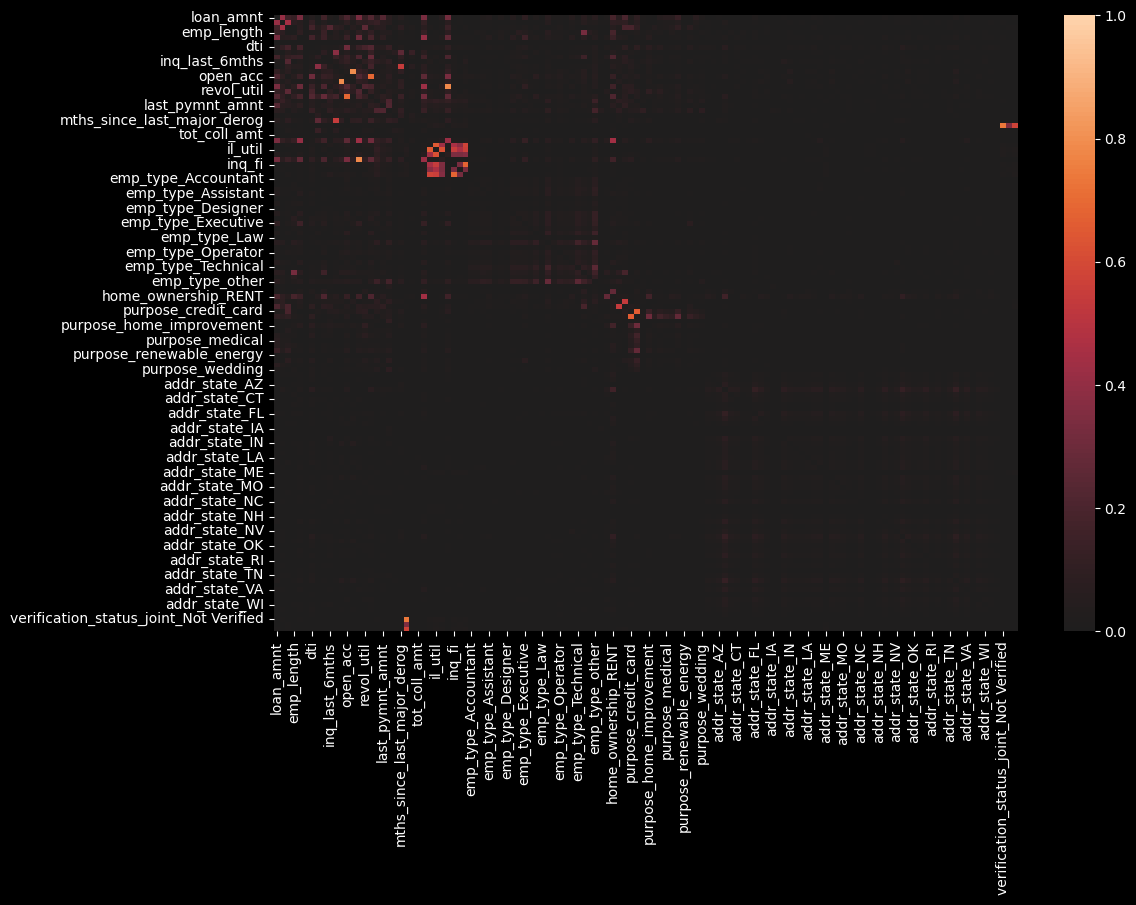

In [189]:
zero_diagonal_heatmap(X_scaled)

In [190]:
corr_dict(X_scaled)

{'mths_since_last_record': 1, 'dti_joint': 1, 'verification_status_joint_Not Verified': 1, 'revol_bal': 1, 'total_rev_hi_lim': 1, 'pub_rec': 1}


In [191]:
corr_list(corr = 0.7, min_corr = 1)

{'mths_since_last_record': ['pub_rec'], 'dti_joint': ['verification_status_joint_Not Verified'], 'verification_status_joint_Not Verified': ['dti_joint'], 'revol_bal': ['total_rev_hi_lim'], 'total_rev_hi_lim': ['revol_bal'], 'pub_rec': ['mths_since_last_record']}


Unsurprisingly two features that both rely on the borrowers having a joint account are collinear. I will drop the dummy variable as the other one contains more information

In [192]:
# Drop the least relevant columns that are in corr_list
X_scaled.drop(['mths_since_last_record', 'total_rev_hi_lim', 'verification_status_joint_Not Verified'], axis = 1, inplace = True)

To make sure that I had fully eliminated the multicollinearity I calculated every remaining feature’s Variance Inflation Factor (VIF). The formula for VIF is:
$$VIF=\frac{1}{1-R^2}$$                                                  
Where ${R^2}$ is the R-squared value that represents correlations.   

In [193]:
# Create vif function with a dataframe as the argument
def vif(dfx):
    #calculate the vif for the dataframe to see if it is non collinear
    vifs = [variance_inflation_factor(dfx.values, i) for i in range(dfx.shape[1])]
    # Put those numbers into a dictionary
    vif_dict = {dfx.columns[i]:vifs[i] for i in range(dfx.shape[1])}
    # Create a filtered dictionary to find out how many features have a VIF under 2.5
    filtered_dict = {k: v for k, v in vif_dict.items() if v < 2.5}
    # Print the amount of columns that aren't collinear out of all the columns
    print(f"{len(filtered_dict)} out of {len(dfx.columns)} features have a vif < 2.5")
    # Create a sorted dictionary based on the values
    vif_dict = {k:v for k, v in sorted(vif_dict.items(), key=lambda item: item[1], reverse = True)}
    # Print the result
    print(vif_dict)

In [194]:
vif(X_scaled)

57 out of 123 features have a vif < 2.5
{'emp_type_other': 169.57974002764598, 'emp_type_Manager': 111.7147586447447, 'emp_type_Technical': 97.59897197456667, 'addr_state_CA': 51.094645200048134, 'emp_type_Unemployed': 46.39212956418784, 'emp_type_Healer': 45.254717422269884, 'addr_state_NY': 31.767745462942365, 'addr_state_TX': 30.633566724669535, 'emp_type_Director': 30.59330240518125, 'emp_type_Education': 27.89717101959111, 'addr_state_FL': 26.705856680717247, 'emp_type_Executive': 26.408281585647327, 'purpose_debt_consolidation': 24.96764806132425, 'emp_type_Vol': 24.23857849854677, 'emp_type_Operator': 23.461031656313015, 'emp_type_Service': 21.245410815327098, 'emp_type_Analyst': 20.537956437604667, 'purpose_credit_card': 18.93967828897951, 'emp_type_Assistant': 18.239376685202956, 'emp_type_Sales': 17.13106743520082, 'addr_state_IL': 16.424458850979022, 'addr_state_NJ': 15.502262195704335, 'addr_state_PA': 14.716247800285, 'addr_state_OH': 13.980629680318021, 'addr_state_GA': 1

In [197]:
corr_dict(X_scaled, corr = .5)

{'il_util': 4, 'inq_last_12m': 3, 'open_acc_6m': 2, 'inq_fi': 2, 'purpose_credit_card': 1, 'dti_joint': 1, 'mths_since_last_major_derog': 1, 'max_bal_bc': 1, 'total_acc': 1, 'verification_status_Source Verified': 1, 'verification_status_Verified': 1, 'verification_status_joint_Verified': 1, 'mths_since_last_delinq': 1, 'purpose_debt_consolidation': 1, 'open_acc': 1}


In [198]:
corr_list(corr= .6, min_corr = 1)

{'il_util': ['open_acc_6m', 'max_bal_bc'], 'inq_last_12m': ['inq_fi'], 'open_acc_6m': ['il_util'], 'inq_fi': ['inq_last_12m'], 'purpose_credit_card': ['purpose_debt_consolidation'], 'dti_joint': [], 'mths_since_last_major_derog': [], 'max_bal_bc': ['il_util'], 'total_acc': ['open_acc'], 'verification_status_Source Verified': [], 'verification_status_Verified': [], 'verification_status_joint_Verified': [], 'mths_since_last_delinq': [], 'purpose_debt_consolidation': ['purpose_credit_card'], 'open_acc': ['total_acc']}


In [195]:
X_scaled.drop(['emp_type_other', 'addr_state_CA', ], axis = 1, inplace = True)

In [196]:
vif(X_scaled)

115 out of 121 features have a vif < 2.5
{'purpose_debt_consolidation': 24.96761119362853, 'purpose_credit_card': 18.93961785627865, 'purpose_home_improvement': 6.5212061819225475, 'purpose_other': 5.602217767774178, 'purpose_major_purchase': 2.896130530451369, 'il_util': 2.730798750721492, 'total_acc': 2.3412250411725206, 'inq_last_12m': 2.2724305415892028, 'open_acc': 2.2366887915277776, 'purpose_small_business': 2.1766772917631436, 'inq_fi': 2.027958161959543, 'open_acc_6m': 1.969223020722815, 'purpose_medical': 1.9541917795725594, 'grade': 1.882609031023419, 'tot_cur_bal': 1.8817109187706282, 'dti_joint': 1.8138544467538595, 'loan_amnt': 1.7700889155867419, 'verification_status_Verified': 1.6876008414952248, 'max_bal_bc': 1.67059263851143, 'home_ownership_RENT': 1.6649091693054299, 'purpose_moving': 1.612957560969563, 'term': 1.6119723224069213, 'mths_since_last_delinq': 1.6024830947155813, 'verification_status_joint_Verified': 1.5951568502705917, 'purpose_vacation': 1.533003660934

In [203]:
X_scaled.drop(['purpose_debt_consolidation'], axis = 1, inplace = True)

In [204]:
vif(X_scaled)

119 out of 120 features have a vif < 2.5
{'il_util': 2.7307888242024836, 'total_acc': 2.34122363770942, 'inq_last_12m': 2.2724287817188364, 'open_acc': 2.2362154778845387, 'inq_fi': 2.027957789717889, 'open_acc_6m': 1.9692149833036792, 'grade': 1.8825266359843544, 'tot_cur_bal': 1.8816856234174637, 'dti_joint': 1.8138513300300452, 'loan_amnt': 1.76378376631423, 'verification_status_Verified': 1.6875362019651317, 'max_bal_bc': 1.6705891495577427, 'home_ownership_RENT': 1.6649046553273368, 'term': 1.6113500489848105, 'mths_since_last_delinq': 1.6024581712519677, 'verification_status_joint_Verified': 1.5951548391405679, 'verification_status_Source Verified': 1.5314865482589934, 'mths_since_last_major_derog': 1.5012617294420394, 'revol_bal': 1.4840021620392303, 'addr_state_TX': 1.471009052033995, 'addr_state_NY': 1.445139520674233, 'annual_inc': 1.4115003680493299, 'addr_state_FL': 1.3856881112765589, 'emp_type_Manager': 1.3845719470330107, 'emp_type_Unemployed': 1.3758843463096149, 'dti':

While I wanted all of the features to be under 2.5, The dataset is still large and running the vif function takes over 10 minutes to run. I will first perform feature selection and then I will return to vif.

In [206]:
y_binary = np.where(loan['loan_status'].isin(['Fully Paid', 'Current', 'Issued']), 1, 0)

## <center> **Lasso Regularization**

Lasso Regularization is a technique for variable selection that uses regression to evaluate the effect that features have on a target variable. The idea is to add a penalty term that contains the coefficient or slope of the variables with respect to the target variable multiplied by parameter. 
\begin{equation}
Loss(β_1,...β_n) = SSD + \alpha|β| \nonumber
\end{equation}
Where $\beta$ is the coefficient of the feature, SSD is the sum of squared distances of the point to the regression line and $\alpha$ is the penalty’s parameter. If there is more than a single feature, then we can sum the coefficients:
\begin{equation}
Loss(β_1,...β_n) = SSD + \alpha* \sum_{i=1}^{n}|β_i| \nonumber
\end{equation}
Lasso aims to reduce the loss in equation (3). If a feature is not important, then changing its slope will not move the regression line close enough to the data points to decrease the loss function with a non-zero value. If a feature is important, the regression line will move towards the data and minimize the SSD faster than it increases the penalty term. Since only features with non-zero coefficients are meaningful, I can discard all the features with a coefficient of zero. 



First we will run a gridsearch to find the best value of $\alpha$, and then we will use the coeffecients from that value of $\alpha$ to determine which features stay in the model.

In [207]:
# Create Lasso model
lasso = Lasso(max_iter = 50000)

# Define hyperparameter grid with a value less than 00.5 since that was the be
params = {'alpha': np.linspace(.0001, .01, 20)}

# Perform grid search
grid_search = GridSearchCV(estimator=lasso, param_grid=params, cv=8)

# fit the gridsearch of parameters to the data
grid_search.fit(X_scaled, y_binary)

# Print best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)


Best hyperparameters:  {'alpha': 0.01}


In [208]:
# Find the coefficients of lasso regularization
lasso = Lasso(alpha = .001)
# Fit the lasso regularization to the data 
lasso.fit(X_scaled, y_binary)
# Create a dictionary of all the features and their corresponding lasso coefficients
lasso_dict = {X_scaled.columns[i]:lasso.coef_[i] for i in range(len(X_scaled.columns)) if list(lasso.coef_)[i] != 0}
# Create a list of all the features that don't have a lasso coefficient of zero
lasso_features = [X_scaled.columns[i] for i in range(len(X_scaled.columns)) if list(lasso.coef_)[i] != 0]
# Print the features and coefficients
print(lasso_dict)
# Print the number of features are left from lasso
print(len(lasso_dict))

{'loan_amnt': -0.010391316872062236, 'term': 0.002948502470419479, 'grade': 0.03788254325234942, 'annual_inc': 0.0022825117307152722, 'pymnt_plan': -0.00023065455231244378, 'inq_last_6mths': -0.016965471271241, 'pub_rec': 0.00328094929656237, 'revol_bal': 0.00017543217177538116, 'revol_util': -0.005030065433174285, 'total_acc': -0.001725540484437378, 'initial_list_status': 0.010934774737318688, 'last_pymnt_amnt': 0.04433076049762753, 'last_credit_pull_d': 0.051610620607713674, 'collections_12_mths_ex_med': 0.0004269000786191071, 'mths_since_last_major_derog': -0.003163609410562672, 'dti_joint': 0.0007302915041974671, 'tot_cur_bal': 0.0021794962954110103, 'open_acc_6m': 0.0023301194338613833, 'il_util': 0.004372566069389636, 'max_bal_bc': 0.0015211874387965623, 'inq_last_12m': 0.001700906513944068, 'emp_type_Accountant': 0.0014560825330323078, 'emp_type_Admin': 0.0011180935599351067, 'emp_type_Analyst': 0.0020839310189119495, 'emp_type_Assistant': 0.001716231097294549, 'emp_type_Clergy'

In [211]:
df = X_scaled[lasso_dict.keys()]

In [212]:
vif(df)

60 out of 61 features have a vif < 2.5
{'il_util': 2.503648536830864, 'open_acc_6m': 1.9535214353509527, 'tot_cur_bal': 1.770654329297814, 'grade': 1.7439133806542608, 'loan_amnt': 1.7138957829652597, 'max_bal_bc': 1.6615584854813974, 'inq_last_12m': 1.6414880361328827, 'verification_status_Verified': 1.625458267723455, 'term': 1.5872880178470525, 'verification_status_Source Verified': 1.523078231850744, 'revol_bal': 1.4016325218077512, 'annual_inc': 1.330297515878795, 'home_ownership_RENT': 1.3073547671221735, 'total_acc': 1.2448280761753376, 'revol_util': 1.2440126800569045, 'emp_type_Manager': 1.2293581030145195, 'last_credit_pull_d': 1.1823828739055637, 'emp_type_Technical': 1.1632605142157963, 'inq_last_6mths': 1.1554307323054438, 'last_pymnt_amnt': 1.140772579699193, 'initial_list_status': 1.1210513382502567, 'emp_type_Executive': 1.1074575667950384, 'emp_type_Healer': 1.0974140074627614, 'purpose_credit_card': 1.090279220777798, 'mths_since_last_major_derog': 1.0872113114911621,

In [213]:
df.to_csv('./data/interim/wrangled', index = False)